In [1]:
#Import things
import numpy as np
import matplotlib.pyplot as plt
import importance_sampler as isamp
import scipy.optimize as op
import chainconsumer as CC
import emcee #for doing MCMC
%matplotlib inline

In [2]:
#Plot formatting
plt.rc("font", size=18, family="serif")
plt.rc("text", usetex=True)

In [3]:
#Read in the chain
input_chain = np.load("Planck_data/Planck_params.npy")
lnpost = np.load("Planck_data/Planck_lnpost.npy")
weights = np.load("Planck_data/Planck_weights.npy")
print("chain shape is   ", input_chain.shape)
print("lnpost shape is  ", lnpost.shape)
print("weights shape is ", weights.shape)

('chain shape is   ', (12250, 27))
('lnpost shape is  ', (12250,))
('weights shape is ', (12250,))


In [4]:
#Pick out training points
N_training = 1000
IS = isamp.ImportanceSampler(input_chain, lnpost, scale = 5)
IS.select_training_points(N_training, method="LH")
#Train the GP inside of the sampler
IS.train()

      fun: 113204.14537323827
 hess_inv: array([[2.79260728e-06]])
      jac: array([-0.00026139])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 59
      nit: 3
     njev: 48
   status: 2
  success: False
        x: array([3.56132021])


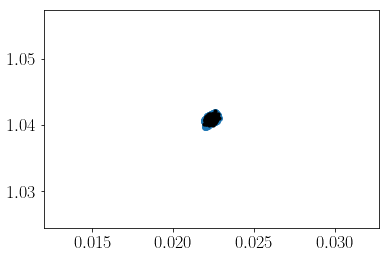

In [5]:
plt.scatter(input_chain[-2000:,0],input_chain[-2000:,2])
points,_ = IS.get_training_data()
plt.scatter(points[:,0], points[:,2], c='k', s=10)

In [ ]:
start = input_chain[np.argmax(lnpost)]

nwalkers = 200
ndim = len(input_chain[0])

sampler = emcee.EnsembleSampler(nwalkers, ndim, IS.predict)

print("Running first burn-in")
p0 = np.array([start + start*1e-3*np.random.randn(ndim) for i in range(nwalkers)])
p0, lp, _ = sampler.run_mcmc(p0, 1000)
print("Running second burn-in")
p0 = p0[np.argmax(lp)] + p0[np.argmax(lp)]*1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 1000)
sampler.reset()
print("Running production...")
sampler.run_mcmc(p0, 1000);

Running first burn-in


In [ ]:
test_chain = sampler.flatchain

In [ ]:
c = CC.ChainConsumer()

plot_input_chain = [input_chain[:,4], input_chain[:,1]]
plot_test_chain = [test_chain[:,4], test_chain[:,1]]

#labels = [r"$\Omega_m$", r"$h$", r"$\Omega_b$", r"$n_s$", r"$A_s$"]
labels = [r"$\ln 10^{10}A_s$", r"$\Omega_ch^2$", ]

c.add_chain(plot_input_chain, parameters=labels, name="Input chain", weights=weights)
c.add_chain(plot_test_chain, parameters=labels, name="Resampled chain")

fig = c.plotter.plot()
#fig.savefig("DESY1_resampling_example.png", dpi=300, bbox_inches="tight")

In [ ]:
c2 = CC.ChainConsumer()

c2.add_chain(input_chain[:,:5], name="Input chain", weights=weights)
c2.add_chain(test_chain[:,:5], name="Resampled chain")

fig = c2.plotter.plot()